In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00


The following results were obtained by training the two modalities separately and combining them through output fusion at the final layer.

Epoch 1, Training Loss: 0.6173, Training Accuracy: 71.88%, Validation Loss: 0.5018, Validation Accuracy: 93.75%
Epoch 2, Training Loss: 0.5898, Training Accuracy: 71.88%, Validation Loss: 0.4925, Validation Accuracy: 93.75%
Epoch 3, Training Loss: 0.5639, Training Accuracy: 75.00%, Validation Loss: 0.4832, Validation Accuracy: 81.25%
Epoch 4, Training Loss: 0.5386, Training Accuracy: 76.56%, Validation Loss: 0.4584, Validation Accuracy: 81.25%
Epoch 5, Training Loss: 0.5105, Training Accuracy: 76.56%, Validation Loss: 0.4345, Validation Accuracy: 81.25%
Epoch 6, Training Loss: 0.4825, Training Accuracy: 76.56%, Validation Loss: 0.4406, Validation Accuracy: 81.25%
Epoch 7, Training Loss: 0.4531, Training Accuracy: 81.25%, Validation Loss: 0.4725, Validation Accuracy: 81.25%
Epoch 8, Training Loss: 0.4243, Training Accuracy: 82.81%, Validation Loss: 0.4943, Validation Accuracy: 81.25%
Epoch 9, Training Loss: 0.3954, Training Accuracy: 82.81%, Validation Loss: 0.5086, Validation Accuracy:

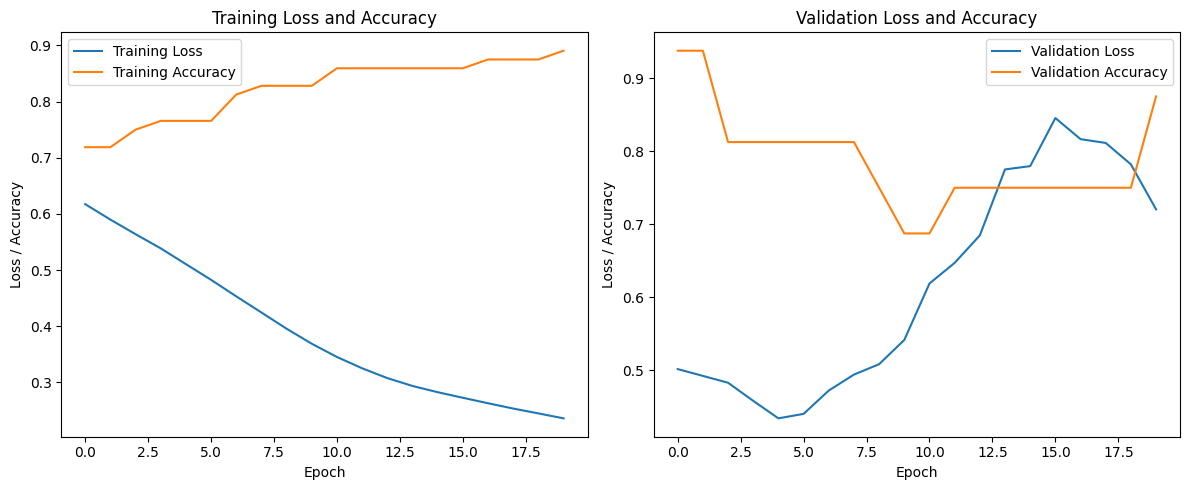

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
df = pd.read_csv("/content/medical_dataset.csv")

# Split the dataset into features and labels
X = df.drop(columns=['class']).values
y = df['class'].values

# Split features into two modalities
X_modality_1 = X[:, :7]  # Features 1 to 7
X_modality_2 = X[:, 7:]  # Features 8 to 10

# Convert data to PyTorch tensors
X_modality_1 = torch.tensor(X_modality_1, dtype=torch.float)
X_modality_2 = torch.tensor(X_modality_2, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Function to create adjacency matrix using cosine similarity
def create_adjacency_matrix(features):
    # Compute cosine similarity between features
    similarity_matrix = cosine_similarity(features)
    # Create adjacency matrix (undirected graph)
    adjacency_matrix = (similarity_matrix > 0.5).astype(int)  # threshold to create edges
    return adjacency_matrix

# Create adjacency matrices for both modalities
adjacency_matrix_1 = create_adjacency_matrix(X_modality_1)
adjacency_matrix_2 = create_adjacency_matrix(X_modality_2)

# Convert adjacency matrices to edge indices for PyTorch Geometric
def adjacency_matrix_to_edge_index(adjacency_matrix):
    edge_index = torch.tensor(np.array(np.nonzero(adjacency_matrix)), dtype=torch.long)
    return edge_index

edge_index_1 = adjacency_matrix_to_edge_index(adjacency_matrix_1)
edge_index_2 = adjacency_matrix_to_edge_index(adjacency_matrix_2)

# Create PyTorch Geometric data objects with the new edge indices
data1 = Data(x=X_modality_1, edge_index=edge_index_1)
data2 = Data(x=X_modality_2, edge_index=edge_index_2)

# The rest of the model setup and training would proceed as before, now using these edge indices
data1.edge_index, data2.edge_index

# Split data into training, validation, and test sets
train_idx, test_idx, y_train, y_test = train_test_split(torch.arange(y.size(0)), y, test_size=0.2, stratify=y, random_state=42)
train_idx, val_idx, y_train, y_val = train_test_split(train_idx, y_train, test_size=0.2, stratify=y_train, random_state=42)

train_data1 = data1.subgraph(train_idx)
train_data2 = data2.subgraph(train_idx)
val_data1 = data1.subgraph(val_idx)
val_data2 = data2.subgraph(val_idx)
test_data1 = data1.subgraph(test_idx)
test_data2 = data2.subgraph(test_idx)

# Define the GCN model for each modality
class GCNModality1(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCNModality1, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        return x

class GCNModality2(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCNModality2, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.relu(self.conv3(x, edge_index))
        return x

# Define the overall model
class MultimodalGCN(nn.Module):
    def __init__(self, gcn1, gcn2, hidden_dim, output_dim):
        super(MultimodalGCN, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, data1, data2):
        x1 = self.gcn1(data1.x, data1.edge_index)
        x2 = self.gcn2(data2.x, data2.edge_index)
        x = torch.cat([x1, x2], dim=1)
        out = self.fc(x)
        return out

# Instantiate the models
hidden_dim = 16
output_dim = 2
gcn1 = GCNModality1(input_dim=7, hidden_dim=hidden_dim)
gcn2 = GCNModality2(input_dim=3, hidden_dim=hidden_dim)
model = MultimodalGCN(gcn1, gcn2, hidden_dim, output_dim)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training and validation loops
epochs = 20  # Reducing to 50 epochs for quick feedback
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    train_output = model(train_data1, train_data2)
    train_loss = criterion(train_output, y_train)
    train_loss.backward()
    optimizer.step()

    _, train_pred = torch.max(train_output, 1)
    train_accuracy = accuracy_score(y_train.cpu(), train_pred.cpu())
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(val_data1, val_data2)
        val_loss = criterion(val_output, y_val)
        _, val_pred = torch.max(val_output, 1)
        val_accuracy = accuracy_score(y_val.cpu(), val_pred.cpu())
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

    # Print metrics
    print(f'Epoch {epoch+1}, Training Loss: {train_loss.item():.4f}, Training Accuracy: {train_accuracy*100:.2f}%, '
          f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy*100:.2f}%')

# Evaluation on test set
model.eval()
with torch.no_grad():
    test_output = model(test_data1, test_data2)
    _, test_pred = torch.max(test_output, 1)
    test_accuracy = accuracy_score(y_test.cpu(), test_pred.cpu())
    precision = precision_score(y_test.cpu(), test_pred.cpu(), average='macro')
    recall = recall_score(y_test.cpu(), test_pred.cpu(), average='macro')
    f1 = f1_score(y_test.cpu(), test_pred.cpu(), average='macro')
    auc = roc_auc_score(y_test.cpu(), nn.functional.softmax(test_output, dim=1).cpu()[:, 1])

# Print evaluation metrics
print(f'\nFinal Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'AUC: {auc:.4f}')

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


The results presented below are obtained by incorporating the Shared Modality block

Epoch 1, Training Loss: 0.6219, Training Accuracy: 65.62%, Validation Loss: 0.4409, Validation Accuracy: 93.75%
Epoch 2, Training Loss: 0.5710, Training Accuracy: 71.88%, Validation Loss: 0.3813, Validation Accuracy: 93.75%
Epoch 3, Training Loss: 0.5261, Training Accuracy: 78.12%, Validation Loss: 0.3350, Validation Accuracy: 100.00%
Epoch 4, Training Loss: 0.4804, Training Accuracy: 82.81%, Validation Loss: 0.2936, Validation Accuracy: 100.00%
Epoch 5, Training Loss: 0.4351, Training Accuracy: 84.38%, Validation Loss: 0.2530, Validation Accuracy: 100.00%
Epoch 6, Training Loss: 0.3901, Training Accuracy: 84.38%, Validation Loss: 0.2153, Validation Accuracy: 100.00%
Epoch 7, Training Loss: 0.3493, Training Accuracy: 87.50%, Validation Loss: 0.1841, Validation Accuracy: 100.00%
Epoch 8, Training Loss: 0.3097, Training Accuracy: 89.06%, Validation Loss: 0.1590, Validation Accuracy: 100.00%
Epoch 9, Training Loss: 0.2757, Training Accuracy: 89.06%, Validation Loss: 0.1375, Validation Acc

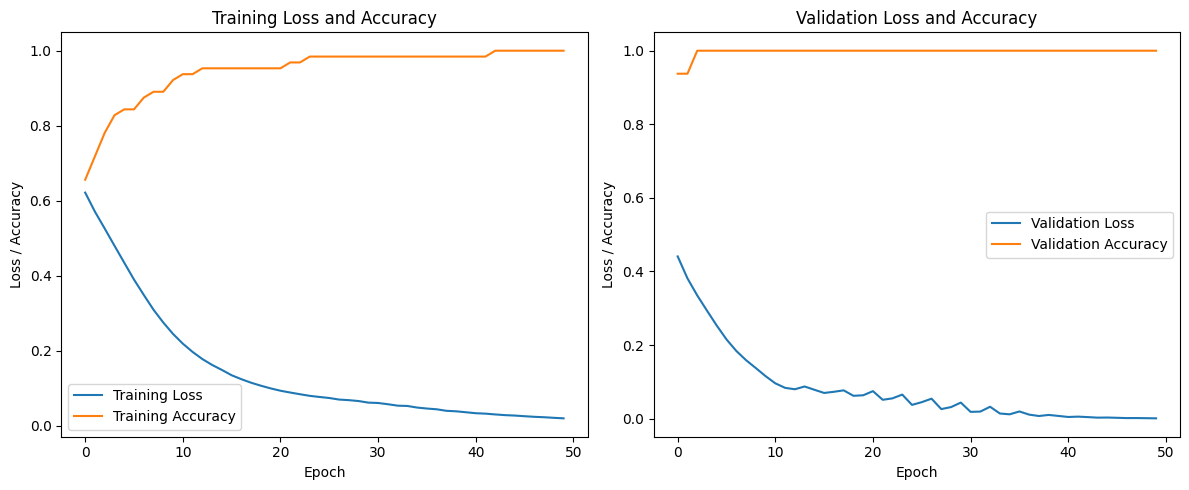

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity



# Load the dataset
df = pd.read_csv("/content/medical_dataset.csv")

# Split the dataset into features and labels
X = df.drop(columns=['class']).values
y = df['class'].values

# Split features into two modalities
X_modality_1 = X[:, :7]  # Features 1 to 7
X_modality_2 = X[:, 7:]  # Features 8 to 10

# Convert data to PyTorch tensors
X_modality_1 = torch.tensor(X_modality_1, dtype=torch.float)
X_modality_2 = torch.tensor(X_modality_2, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Function to create adjacency matrix using cosine similarity
def create_adjacency_matrix(features):
    # Compute cosine similarity between features
    similarity_matrix = cosine_similarity(features)
    # Create adjacency matrix (undirected graph)
    adjacency_matrix = (similarity_matrix > 0.4).astype(int)  # threshold to create edges
    return adjacency_matrix

# Create adjacency matrices for both modalities
adjacency_matrix_1 = create_adjacency_matrix(X_modality_1)
adjacency_matrix_2 = create_adjacency_matrix(X_modality_2)

# Convert adjacency matrices to edge indices for PyTorch Geometric
def adjacency_matrix_to_edge_index(adjacency_matrix):
    edge_index = torch.tensor(np.array(np.nonzero(adjacency_matrix)), dtype=torch.long)
    return edge_index

edge_index_1 = adjacency_matrix_to_edge_index(adjacency_matrix_1)
edge_index_2 = adjacency_matrix_to_edge_index(adjacency_matrix_2)

# Create PyTorch Geometric data objects with the new edge indices
data1 = Data(x=X_modality_1, edge_index=edge_index_1)
data2 = Data(x=X_modality_2, edge_index=edge_index_2)

# The rest of the model setup and training would proceed as before, now using these edge indices
data1.edge_index, data2.edge_index

# Create random edges for the graph (for simplicity, a fully connected graph for each modality)
#edge_index_1 = torch.combinations(torch.arange(X_modality_1.size(0)), r=2).t().contiguous()
#edge_index_2 = torch.combinations(torch.arange(X_modality_2.size(0)), r=2).t().contiguous()

# Create PyTorch Geometric data objects
data1 = Data(x=X_modality_1, edge_index=edge_index_1)
data2 = Data(x=X_modality_2, edge_index=edge_index_2)
# Combine the features from modality 1 and 2 to create a new dataset for the third GCN
X_combined = torch.cat([X_modality_1, X_modality_2], dim=1)

# Create the adjacency matrix and edge index for the combined dataset
adjacency_matrix_3 = create_adjacency_matrix(X_combined)
edge_index_3 = adjacency_matrix_to_edge_index(adjacency_matrix_3)

# Create a PyTorch Geometric data object for the combined features
data3 = Data(x=X_combined, edge_index=edge_index_3)

# Split data into training, validation, and test sets
train_idx, test_idx, y_train, y_test = train_test_split(torch.arange(y.size(0)), y, test_size=0.2, stratify=y, random_state=42)
train_idx, val_idx, y_train, y_val = train_test_split(train_idx, y_train, test_size=0.2, stratify=y_train, random_state=42)

train_data1 = data1.subgraph(train_idx)
train_data2 = data2.subgraph(train_idx)
train_data3 = data3.subgraph(train_idx)

val_data1 = data1.subgraph(val_idx)
val_data2 = data2.subgraph(val_idx)
val_data3 = data3.subgraph(val_idx)

test_data1 = data1.subgraph(test_idx)
test_data2 = data2.subgraph(test_idx)
test_data3 = data3.subgraph(test_idx)

# Define the GCN model for each modality
class GCNModality1(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCNModality1, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        return x

class GCNModality2(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCNModality2, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.relu(self.conv3(x, edge_index))
        return x

# Define the additional GCN model for learning features from both modalities combined
class GCNModality3(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCNModality3, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        return x

# Instantiate the new GCN model for all features combined

# Define the overall model
'''class MultimodalGCN(nn.Module):
    def __init__(self, gcn1, gcn2, hidden_dim, output_dim):
        super(MultimodalGCN, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, data1, data2):
        x1 = self.gcn1(data1.x, data1.edge_index)
        x2 = self.gcn2(data2.x, data2.edge_index)
        x = torch.cat([x1, x2], dim=1)
        out = self.fc(x)
        return out'''

# Modify the overall model to include the third GCN and concatenate all features
class MultimodalGCNModified(nn.Module):
    def __init__(self, gcn1, gcn2, gcn3, hidden_dim, output_dim):
        super(MultimodalGCNModified, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.gcn3 = gcn3
        self.fc = nn.Linear(hidden_dim * 3, output_dim)  # Adjusted for three GCNs

    def forward(self, data1, data2, data3):
        x1 = self.gcn1(data1.x, data1.edge_index)
        x2 = self.gcn2(data2.x, data2.edge_index)
        x3 = self.gcn3(data3.x, data3.edge_index)
        x_concat = torch.cat([x1, x2, x3], dim=1)  # Concatenate all features from the three GCNs
        out = self.fc(x_concat)
        return out


# Instantiate the models
hidden_dim = 16
output_dim = 2
gcn1 = GCNModality1(input_dim=7, hidden_dim=hidden_dim)
gcn2 = GCNModality2(input_dim=3, hidden_dim=hidden_dim)
gcn3 = GCNModality3(input_dim=10, hidden_dim=hidden_dim)


# Instantiate the modified model
model_modified = MultimodalGCNModified(gcn1, gcn2, gcn3, hidden_dim, output_dim)

#model = MultimodalGCN(gcn1, gcn2, hidden_dim, output_dim)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_modified.parameters(), lr=0.01)

# Training and validation loops
epochs = 50  # Reducing to 50 epochs for quick feedback
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    model_modified.train()
    optimizer.zero_grad()
    train_output = model_modified(train_data1, train_data2, train_data3)
    train_loss = criterion(train_output, y_train)
    train_loss.backward()
    optimizer.step()

    _, train_pred = torch.max(train_output, 1)
    train_accuracy = accuracy_score(y_train.cpu(), train_pred.cpu())
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy)

    # Validation
    model_modified.eval()
    with torch.no_grad():
        val_output = model_modified(val_data1, val_data2, val_data3)
        val_loss = criterion(val_output, y_val)
        _, val_pred = torch.max(val_output, 1)
        val_accuracy = accuracy_score(y_val.cpu(), val_pred.cpu())
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

    # Print metrics
    print(f'Epoch {epoch+1}, Training Loss: {train_loss.item():.4f}, Training Accuracy: {train_accuracy*100:.2f}%, '
          f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy*100:.2f}%')

# Evaluation on test set
model_modified.eval()
with torch.no_grad():
    test_output = model_modified(test_data1, test_data2, test_data3)
    _, test_pred = torch.max(test_output, 1)
    test_accuracy = accuracy_score(y_test.cpu(), test_pred.cpu())
    precision = precision_score(y_test.cpu(), test_pred.cpu(), average='macro')
    recall = recall_score(y_test.cpu(), test_pred.cpu(), average='macro')
    f1 = f1_score(y_test.cpu(), test_pred.cpu(), average='macro')
    auc = roc_auc_score(y_test.cpu(), nn.functional.softmax(test_output, dim=1).cpu()[:, 1])

# Print evaluation metrics
print(f'\nFinal Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'AUC: {auc:.4f}')

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
